In [7]:
import cv2  # Still used for image I/O and adding noise
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)

OpenCV version: 4.9.0


# Set up

In [8]:

# Fourier Transformation Utility Functions using NumPy
def fft2(u):
    return np.fft.fftshift(np.fft.fft2(u))

def ifft2(u_hat):
    # return np.fft.ifft2(np.fft.ifftshift(u_hat)).real
    return np.fft.ifft2(np.fft.ifftshift(u_hat))

# Backward and Central Fractional Derivatives
def Dx(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
    complex_term = 1 - np.exp((-1j * 2 * np.pi * w1_grid[:, None]) / M)
    K = np.power(complex_term, alpha)
    dx_hat = u_hat * K
    dx = ifft2(dx_hat)
    return dx

def Dy(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
    complex_term = 1 - np.exp((-1j * 2 * np.pi * w2_grid) / N)
    K = np.power(complex_term, alpha)
    dy_hat = u_hat * K
    dy = ifft2(dy_hat)
    return dy

def central_Dx(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
    complex_term = np.exp((1j * np.pi * w1_grid[:, None]) / M) - np.exp((-1j * np.pi * w1_grid[:, None]) / M)
    K = np.power(complex_term, alpha)
    dx_hat = u_hat * K
    dx = ifft2(dx_hat)
    return dx

def central_Dy(u, alpha):
    u_hat = fft2(u)
    M, N = u.shape
    w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
    complex_term = np.exp((1j * np.pi * w2_grid) / N) - np.exp((-1j * np.pi * w2_grid) / N)
    K = np.power(complex_term, alpha)
    dy_hat = u_hat * K
    dy = ifft2(dy_hat)
    return dy

# Diffusion Coefficient Computation
def C(u, alpha, beta):
    D = np.sqrt(np.square(Dx(u, alpha)) + np.square(Dy(u, alpha)))
    mu_nn_numerator = np.square(Dx(u, beta)) * Dx(Dx(u, beta), beta) + 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dy(Dy(u, beta), beta)
    mu_nn_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    mu_nn = mu_nn_numerator / mu_nn_denominator
    mu_ee_numerator = np.square(Dx(u, beta)) * Dy(Dy(u, beta), beta) - 2 * Dx(u, beta) * Dy(u, beta) * Dx(Dy(u, beta), beta) + np.square(Dy(u, beta)) * Dx(Dx(u, beta), beta)
    mu_ee_denominator = np.square(Dx(u, beta)) + np.square(Dy(u, beta)) + 0.001
    mu_ee = mu_ee_numerator / mu_ee_denominator
    fDC = np.abs(np.abs(mu_nn) - np.abs(mu_ee))
    c = 1 / (1 + D + fDC)
    return c

# Compute Kx and Ky using NumPy
def make_K(M, N, alpha):
    w1_grid = np.fft.fftshift(np.fft.fftfreq(M) * M)
    w2_grid = np.fft.fftshift(np.fft.fftfreq(N) * N)
    complex_term_x = np.exp((1j * np.pi * w1_grid[:, None]) / M) - np.exp((-1j * np.pi * w1_grid[:, None]) / M)
    complex_term_y = np.exp((1j * np.pi * w2_grid) / N) - np.exp((-1j * np.pi * w2_grid) / N)
    Kx = np.power(complex_term_x, alpha)
    Ky = np.power(complex_term_y, alpha)
    return Kx, Ky

# Execution

In [9]:
# Simulation Parameters
dt = 0.01
alpha = 1.9
beta = 1.1

# Image Loading and Noise Addition
u_clean = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
mean = 0
std = 20
noise = np.random.normal(mean, std, u_clean.shape)
u_noisy = u_clean + noise
u = u_noisy.copy()

# Compute Kx and Ky
M, N = u.shape
Kx, Ky = make_K(M, N, alpha)

# Denoising Loop
i = 0
prev_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
while True:
    i += 1
    print(f"Iteration {i}")

    u_hat = np.fft.fftshift(np.fft.fft2(u))
    c = C(u, alpha, beta)
    gx = c * central_Dx(u, alpha)
    gy = c * central_Dy(u, alpha)

    gx_hat = np.fft.fftshift(np.fft.fft2(gx))
    gy_hat = np.fft.fftshift(np.fft.fft2(gy))

    # Compute the combined g_hat using the conjugates of Kx and Ky
    g_hat = (np.conj(Kx) * gx_hat) + (np.conj(Ky) * gy_hat)

    # Perform iteration
    u_hat = u_hat - g_hat * dt
    u = np.fft.ifft2(np.fft.ifftshift(u_hat)).real

    current_PSNR = cv2.PSNR(u_clean.astype('float32'), u.astype('float32'))
    if i > 100:
        break
    else:
        prev_PSNR = current_PSNR
        u_denoised = u.copy()  # Update denoised image after the loop

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

# Display Results

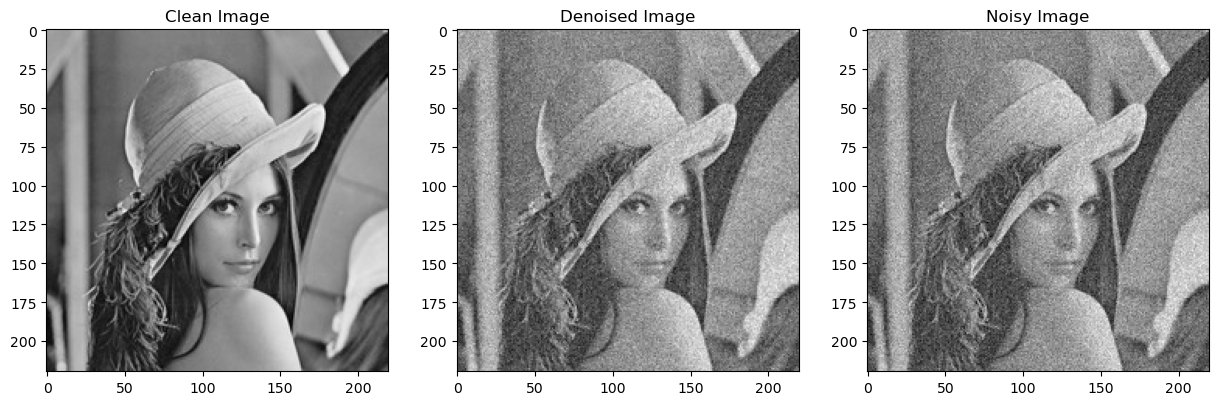

The arrays have different values.
Mean absolute difference: 2.5406274481019926
Maximum absolute difference: 19.168664542763988
Minimum absolute difference: 1.8102669848474306e-05


In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
ax1.imshow(u_clean, cmap='gray')
ax1.set_title('Clean Image')

# Plot the denoised image
ax2.imshow(u_denoised, cmap='gray')
ax2.set_title('Denoised Image')

# Plot the noisy image
ax3.imshow(u_noisy, cmap='gray')
ax3.set_title('Noisy Image')

plt.show()

if np.array_equal(u_denoised, u_noisy):
    print("The arrays have the same values.")
else:
    print("The arrays have different values.")

absolute_diff = np.abs(u_noisy - u_denoised)

# Calculate various statistics to quantify the difference
mean_abs_diff = np.mean(absolute_diff)
max_abs_diff = np.max(absolute_diff)
min_abs_diff = np.min(absolute_diff)

print("Mean absolute difference:", mean_abs_diff)
print("Maximum absolute difference:", max_abs_diff)
print("Minimum absolute difference:", min_abs_diff)

## Run the following commands in the terminal (cmd + J) if import cv2 glitches again

- conda activate base
- conda remove opencv
- conda remove opencv-python
- pip uninstall opencv
- pip uninstall opencv-python
- pip uninstall opencv-python-headless
- pip install opencv-python-headless